In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.7 MB/s eta 0:00:00


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# Define a ticker and a date range for your data
ticker = 'SPY'  # S&P 500 ETF, a good proxy for the market
start_date = '2010-01-01'
end_date = '2025-07-31'

# Download historical data from Yahoo Finance
# We will explicitly use auto_adjust=True to get the adjusted closing prices.
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

display(data)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.515625,85.560897,84.142305,84.791237,118944600
2010-01-05,85.741997,85.779728,85.153432,85.462809,111579900
2010-01-06,85.802383,86.013663,85.591104,85.659013,116074400
2010-01-07,86.164574,86.270213,85.402454,85.643917,131091100
2010-01-08,86.451324,86.489055,85.764667,85.938215,126402800
...,...,...,...,...,...
2025-07-24,634.419983,636.150024,633.989990,634.599976,71307100
2025-07-25,637.099976,637.580017,634.840027,635.090027,56865400


Data for SPY from 2010-01-01 to 2025-07-31
--------------------------------------------------
Ticker          SPY
count   3916.000000
mean       0.051177
std        1.094580
min      -11.588655
25%       -0.371790
50%        0.069387
75%        0.578550
max        9.986286
--------------------------------------------------


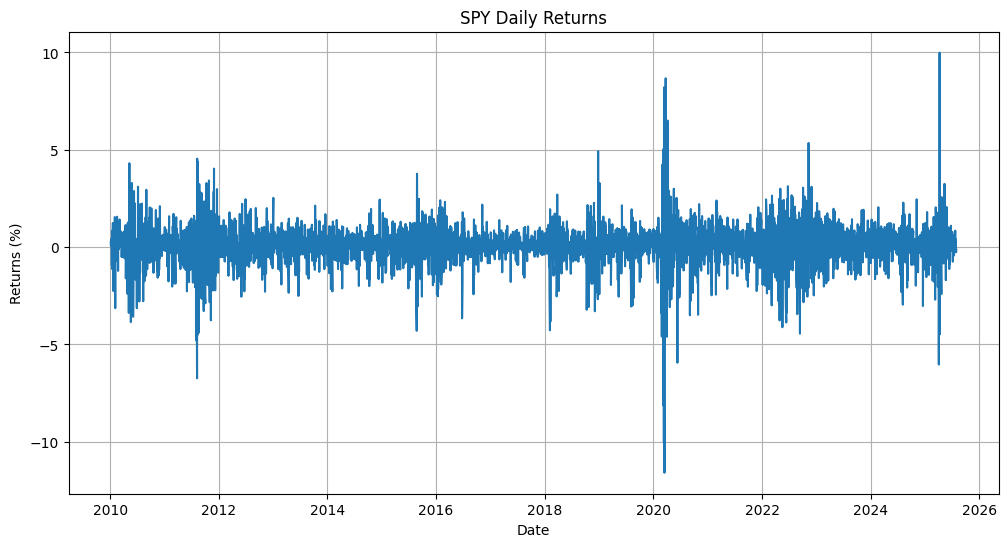

In [7]:
# Calculate logarithmic returns
# GARCH models are typically applied to returns, not raw prices.
# Log returns are often preferred as they are time-additive and more symmetric.
# Calculate logarithmic returns
returns = 100 * np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Print a summary of the data
print(f"Data for {ticker} from {start_date} to {end_date}")
print("-" * 50)
print(returns.describe())
print("-" * 50)

# Optional: Plot the returns to visualize volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title(f'{ticker} Daily Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# The 'returns' Series is now ready to be used in the next cell for GARCH modeling.

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5041.42
Distribution:                  Normal   AIC:                           10090.8
Method:            Maximum Likelihood   BIC:                           10115.9
                                        No. Observations:                 3916
Date:                Fri, Aug 01 2025   Df Residuals:                     3915
Time:                        17:42:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0871  1.196e-02      7.287  3.176e-13 [6.371e-0

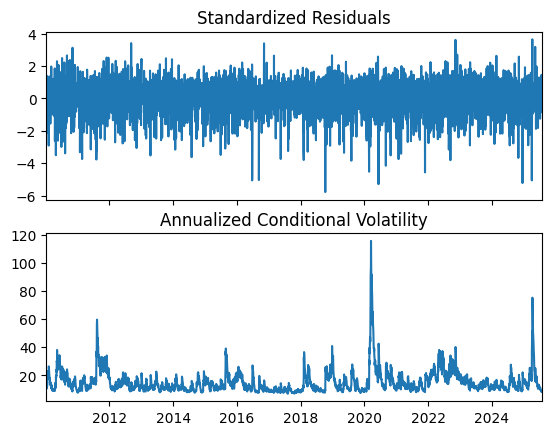

In [8]:
# Create a GARCH model
# This uses a standard GARCH(1,1) model with a constant mean.
# 'p' is the order of the ARCH term (past squared residuals).
# 'q' is the order of the GARCH term (past conditional variances).
am = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant')

# Fit the model to the data
res = am.fit(disp='off')  # disp='off' suppresses the optimization output

# Print the model summary
print(res.summary())

# Plot the conditional volatility from the model
fig = res.plot(annualize='D')